In [5]:
!pip install catboost
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.3/365.3 KB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.5/210.5 KB 22.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 KB 8.9 MB/s eta 0:00:00


In [10]:
import pandas as pd
import random
import os
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import regularizers
from keras.models import Sequential
from keras.layers import Dense,Dropout, Activation

from sklearn.metrics import f1_score
from catboost import CatBoostClassifier

import optuna
from optuna.samplers import TPESampler
from optuna import Trial

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
# train_df = pd.read_csv('C://Users//user//OneDrive//open//train.csv')
# test_df = pd.read_csv('C:/Users/user/OneDrive/open/test.csv')
# submit = pd.read_csv('C:/Users/user/OneDrive/open/sample_submission.csv')

In [177]:
train_df = pd.read_csv('/content/drive/MyDrive/train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/test.csv')

In [178]:
train_x = train_df.drop(columns=['PRODUCT_ID', 'TIMESTAMP', 'Y_Class'])
train_y = train_df['Y_Class']

test_x = test_df.drop(columns=['PRODUCT_ID', 'TIMESTAMP'])
# test_x = test_df

# 1.preprocessing

In [179]:
# qualitative to quantitative
qual_col = ['LINE', 'PRODUCT_CODE']

for i in qual_col:
    le = LabelEncoder()
    le = le.fit(train_x[i])
    train_x[i] = le.transform(train_x[i])
    
    for label in np.unique(test_x[i]): 
        if label not in le.classes_: 
            le.classes_ = np.append(le.classes_, label)
    test_x[i] = le.transform(test_x[i]) 
print('Done.')  


Done.


In [180]:
train_x = train_x.fillna(0)
test_x = test_x.fillna(0)

In [183]:
from sklearn.preprocessing import MinMaxScaler

stdsc = MinMaxScaler()

X_train_std = stdsc.fit_transform(train_x)
X_test_std = stdsc.transform(test_x)  

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names seen at fit time, yet now missing:
- Y_Quality

  warnings.warn(message, FutureWarning)


ValueError: ignored

In [ ]:
# X_train_std = pd.DataFrame(X_train_std)
# X_test_std = pd.DataFrame(X_test_std)

In [ ]:
# X_train_std

array([[ 0.34307569, -0.71324153, -1.17783182, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.47703624, -0.12575057, -1.17783182, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.05008771, -0.71324153, -1.17783182, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-1.29915998, -0.71324153, -1.17783182, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.06468338,  0.46174038, -0.1599945 , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.37935041,  1.04923134, -0.1599945 , ...,  0.        ,
         0.        ,  0.        ]])

In [130]:
X_train, X_test, y_train, y_test = train_test_split(X_train_std, train_y,
                                                   test_size=0.3,
                                                   random_state=305)

In [143]:
model = Sequential([
          Dense(512, activation='relu',input_shape=(2877,)),
          Dense(3, activation='softmax')])

model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 512)               1473536   
                                                                 
 dense_13 (Dense)            (None, 3)                 1539      
                                                                 
Total params: 1,475,075
Trainable params: 1,475,075
Non-trainable params: 0
_________________________________________________________________


In [132]:
train_y

0      1
1      2
2      1
3      2
4      1
      ..
593    1
594    0
595    0
596    1
597    1
Name: Y_Class, Length: 598, dtype: int64

# 2.catboost Classiifer

In [139]:
model.compile(optimizer='adam',
                   loss='sparse_categorical_crossentropy',
                   metrics=['accuracy'])
     

history = model.fit(X_train_std,
                    train_y,
                    epochs=10,
                    batch_size=80,
                    validation_split=0.2)

Epoch 1/10
6/6 [==============================] - 1s 76ms/step - loss: 1.9864 - accuracy: 0.5795 - val_loss: 1.4810 - val_accuracy: 0.5583
Epoch 2/10
6/6 [==============================] - 0s 33ms/step - loss: 1.1174 - accuracy: 0.6444 - val_loss: 1.0912 - val_accuracy: 0.6167
Epoch 3/10
6/6 [==============================] - 0s 37ms/step - loss: 0.8234 - accuracy: 0.7134 - val_loss: 1.0253 - val_accuracy: 0.6833
Epoch 4/10
6/6 [==============================] - 0s 41ms/step - loss: 0.7412 - accuracy: 0.7050 - val_loss: 0.9175 - val_accuracy: 0.6667
Epoch 5/10
6/6 [==============================] - 0s 43ms/step - loss: 0.7208 - accuracy: 0.7197 - val_loss: 0.9714 - val_accuracy: 0.6333
Epoch 6/10
6/6 [==============================] - 0s 43ms/step - loss: 0.7006 - accuracy: 0.7385 - val_loss: 0.9098 - val_accuracy: 0.6833
Epoch 7/10
6/6 [==============================] - 0s 40ms/step - loss: 0.7090 - accuracy: 0.7448 - val_loss: 0.9326 - val_accuracy: 0.6167
Epoch 8/10
6/6 [===========

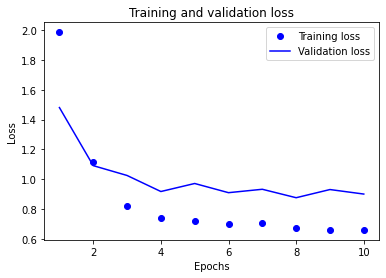

In [140]:
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

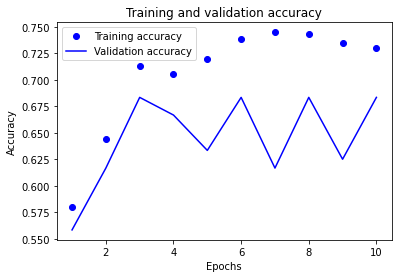

In [141]:
plt.clf()
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()
     

In [111]:
X_train

array([[-0.85592158, -0.71324153, -1.17783182, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.18187866,  0.46174038,  0.85784283, ...,  0.        ,
         0.        ,  0.        ],
       [-0.46119267, -1.88822344, -1.17783182, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.67347484,  0.46174038, -0.1599945 , ...,  0.        ,
         0.        ,  0.        ],
       [-0.34120702,  1.04923134,  0.85784283, ...,  0.        ,
         0.        ,  0.        ],
       [-0.54919633, -1.30073248, -1.17783182, ...,  0.        ,
         0.        ,  0.        ]])

In [144]:
X_test_std = stdsc.transform(test_x) 

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names seen at fit time, yet now missing:
- Y_Quality

  warnings.warn(message, FutureWarning)


ValueError: ignored

In [154]:
# a = pd.DataFrame(test_x.iloc[:,-1:])
# test_x = pd.concat([test_x ,a ])

In [160]:
preds = model.predict(test_x)

preds = preds.astype(int)

39/39 [==============================] - 1s 12ms/step


In [161]:
submit = pd.read_csv('/content/drive/MyDrive/sample_submission.csv')  

submit['Y_Class'] = preds 
submit.to_csv('smartFactory_submission17.csv', index=False)  

ValueError: ignored

In [ ]:
submit['Y_Class'] = preds
     

# submit.to_csv('C:/Users/user/OneDrive/open/mid_submission-MLP.csv', index=False)
submit.to_csv('mid_submission-MLP.csv', index=False)

# 3.optimization

In [ ]:
X_train, X_test, y_train, y_test =train_test_split(train_x, train_y,
                                                   test_size=0.3,
                                                   random_state=1)
     

def objective(trial):
    model = CatBoostClassifier(
        iterations=trial.suggest_int("iterations", 100, 1000),
        learning_rate=trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True),
        depth=trial.suggest_int("depth", 4, 10),
        l2_leaf_reg=trial.suggest_float("l2_leaf_reg", 1e-8, 100.0, log=True),
        bootstrap_type=trial.suggest_categorical("bootstrap_type", ["Bayesian"]),
        random_strength=trial.suggest_float("random_strength", 1e-8, 10.0, log=True),
        bagging_temperature=trial.suggest_float("bagging_temperature", 0.0, 10.0),
        od_type=trial.suggest_categorical("od_type", ["IncToDec", "Iter"]),
        od_wait=trial.suggest_int("od_wait", 10, 50),
        verbose=False
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return f1_score(y_test, y_pred, average='macro')
     

optuna.logging.set_verbosity(optuna.logging.WARNING)

sampler = TPESampler(seed=316)
study = optuna.create_study(study_name="catboost", direction="maximize", sampler=sampler)
study.optimize(objective, n_trials=10)

In [ ]:
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: ", trial.value)
print("  Params: ",trial.params)

In [ ]:
print("Best Score:", study.best_value)
print("Best trial:", study.best_trial.params)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_pred, y_test))

In [ ]:
import pickle
pickle.dump(model, open("catboost_model.pkl", "wb"))
     

optuna.visualization.plot_optimization_history(study)
     

optuna.visualization.plot_parallel_coordinate(study)
     

# 각 파라미터들의 상관관계
optuna.visualization.plot_contour(
    study,
    params=[
        "iterations",
        "learning_rate",
        "depth",
        "l2_leaf_reg",
        "bootstrap_type",
        "random_strength",
        "bagging_temperature",
        "od_type",
        "od_wait"
        ],
)

In [ ]:
# 하이퍼파라미터 중요도
optuna.visualization.plot_param_importances(study)

In [ ]:
preds = model.predict(test_x)
     

preds

In [ ]:
submit = pd.read_csv('C:/Users/user/OneDrive/open/sample_submission.csv')
submit['Y_Class'] = preds

# submit.to_csv('C:/Users/user/OneDrive/open/smartFactory_submission_MLP.csv', index=False)
submit.to_csv('smartFactory_submission.csv', index=False)